# KNN

In [12]:
from preprocessing import *
from aux import *

In [13]:
import matplotlib

from sklearn.neighbors import KNeighborsClassifier

sns.set()

df_data = pd.read_csv('https://drive.google.com/uc?export=download&id=1i-KJ2lSvM7OQH0Yd59bX01VoZcq8Sglq')
df_decision = pd.read_csv('https://drive.google.com/uc?export=download&id=1km-AEIMnWVGqMtK-W28n59hqS5Kufhd0')

In [14]:
df_data.head()

,tipo_de_sala,nombre,id_usuario,genero,edad,amigos,parientes,id_ticket,precio_ticket,fila,nombre_sede
0,4d,Señor Camilo Pedro,117,hombre,73.5,0,0,59258;,1,NaN,fiumark_quilmes
1,4d,Señora Raquel Angelica,658,mujer,35.0,1,1,586:6;,2,NaN,fiumark_quilmes
2,normal,Señor Antonio Federico,794,hombre,NaN,0,0,"RE""39822",3,NaN,fiumark_chacarita
3,4d,Señor Osvaldo Aureliano,455,hombre,NaN,0,0,"C17""4:39",1,NaN,fiumark_palermo
4,4d,Señorita Rita Eudosia,173,mujer,4.0,1,1,569964,2,NaN,fiumark_palermo


## Preprocesado 1

In [15]:
columnillas = ['tipo_de_sala_4d', 'tipo_de_sala_normal', 'tipo_de_sala_nan', 'id_usuario', 'genero_mujer', 'genero_nan', 
              'edad', 'amigos', 'parientes', 'precio_ticket', 'fila_medio', 'fila_nan',
              'nombre_sede_fiumark_palermo', 'nombre_sede_fiumark_quilmes', 'nombre_sede_nan', 
              'cant_acompañantes']

In [16]:
# Asi me ahorro copy pastear esta celda varias veces
def correr_todos_los_preprocesados(dataset, columnas):
    df = eliminar_features_que_no_aportan_info(dataset, False)
    df = crear_feature_acompañantes(df)
    df = replace_nulls_column(df, 'edad', 'media')
    df = normalizar_atributos_numericos(df)
    features_a_encodear = ['nombre_sede','genero', 'tipo_de_sala', 'fila']
    df = encodear_atributos_categoricos(df, features_a_encodear)
    df = df.reindex(columns = columnas)
    return df

In [17]:
volver = ['volveria']
columnas = columnillas + volver

In [18]:
dataset = pd.merge(df_data, df_decision, how='inner', left_on='id_usuario', right_on='id_usuario')

df = correr_todos_los_preprocesados(dataset, columnas)

df.head()

,tipo_de_sala_4d,tipo_de_sala_normal,tipo_de_sala_nan,id_usuario,genero_mujer,genero_nan,edad,amigos,parientes,precio_ticket,fila_medio,fila_nan,nombre_sede_fiumark_palermo,nombre_sede_fiumark_quilmes,nombre_sede_nan,cant_acompañantes,volveria
0,1,0,0,0.130337,0,0,0.880653,0.000,0.000000,0.000000,0,1,0,1,0,0.0,0.0
1,1,0,0,0.738202,1,0,0.396985,0.125,0.166667,0.020408,0,1,0,1,0,0.2,0.0
2,0,1,0,0.891011,0,0,0.368090,0.000,0.000000,0.040816,0,1,0,0,0,0.0,0.0
3,1,0,0,0.510112,0,0,0.368090,0.000,0.000000,0.000000,0,1,1,0,0,0.0,0.0
4,1,0,0,0.193258,1,0,0.007538,0.125,0.166667,0.020408,0,1,1,0,0,0.2,1.0


In [19]:
df.shape

(801, 17)

## Entrenamiento

In [20]:
knn_params = {'n_neighbors': np.arange(3, 10),
              'weights': ['uniform','distance'],
              'algorithm': ['auto', 'ball_tree', 'kd_tree'],
              'leaf_size': np.arange(15, 40),
              'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski']
             }


X, y = split_dataset_X_y(df, columnillas)
model_knn = KNeighborsClassifier()

best_params, X_train, X_test, y_train, y_test = fit_model_grid_search (X, y, model_knn, knn_params)

knn = KNeighborsClassifier(
    n_neighbors = best_params['n_neighbors'],
    weights = best_params['weights'],
    algorithm = best_params['algorithm'],
    leaf_size = best_params['leaf_size'],
    metric= best_params['metric']
)

knn = apply_stratified_k_fold(X, y, knn)

X.shape:  (801, 16)
y.shape:  (801,) 

Best score: 0.8334312573443008
Best params {'algorithm': 'auto', 'leaf_size': 15, 'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}

Fold 0: AUC ROC score is 0.7196
Fold 1: AUC ROC score is 0.7654
Fold 2: AUC ROC score is 0.7988
Fold 3: AUC ROC score is 0.7774
Fold 4: AUC ROC score is 0.8030
Mean test AUC ROC is: 0.7728


## Métricas

In [21]:
scores = get_scores(knn, X_test, y_test)

AUC ROC : 0.9845
Accuracy : 0.9652
Precision : 1.0000
Recall : 1.0000
F1-Score : 0.9524


## Matriz de confusión

/home/anarella/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[0.0, 1.0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


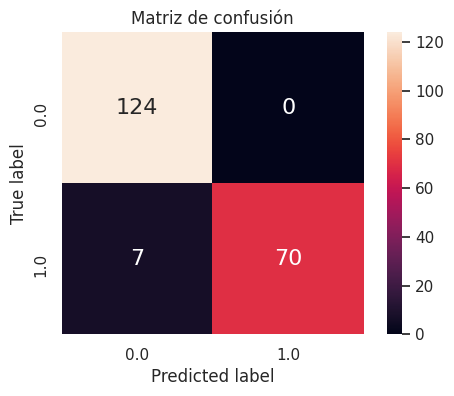

In [22]:
plot_confusion_matrix(y_test, knn.predict(X_test))

## Test Holdout

In [23]:
holdout = pd.read_csv('https://drive.google.com/uc?export=download&id=1I980-_K9iOucJO26SG5_M8RELOQ5VB6A')

In [24]:
df_h = correr_todos_los_preprocesados(holdout, columnillas)
df_h.head()

,tipo_de_sala_4d,tipo_de_sala_normal,tipo_de_sala_nan,id_usuario,genero_mujer,genero_nan,edad,amigos,parientes,precio_ticket,fila_medio,fila_nan,nombre_sede_fiumark_palermo,nombre_sede_fiumark_quilmes,nombre_sede_nan,cant_acompañantes
0,1,0,0,0.751756,1,0,0.344774,0.0,0.0,0.000000,0,1,1,0,0,0.0
1,1,0,0,0.264637,1,0,0.063963,0.5,0.4,0.061224,0,1,1,0,0,0.6
2,0,1,0,0.026932,0,0,0.609984,0.0,0.0,0.040816,0,1,0,0,0,0.0
3,0,0,0,0.637002,0,0,0.407176,0.0,0.0,0.040816,0,1,1,0,0,0.0
4,1,0,0,0.471897,0,0,0.450858,0.0,0.0,0.000000,0,1,1,0,0,0.0


In [25]:
df_resultado = evaluate_holdout(holdout, df_h, knn)
df_resultado.head(15)

y_pred.shape:  (90,)
holdout_df.shape:  (90, 16) 



,id_usuario,volveria
0,650,0
1,234,0
2,31,0
3,552,0
4,411,0
5,134,1
6,497,1
7,434,0
8,528,0
9,112,0


In [26]:
df_resultado.to_csv('prediccion/knn_resultado_final.csv')

## Preprocesado 2

In [32]:
def segundo_set_de_preprocesados(dataset, columnas):
    df = eliminar_features_que_no_aportan_info(dataset, False)
    df = crear_feature_acompañantes(df)
    df = eliminar_features(df, ['amigos'])
    df = replace_nulls_column(df, 'edad', 'media')
    df = normalizar_atributos_numericos(df)
    features_a_encodear = ['fila','nombre_sede','genero', 'tipo_de_sala']
    df = encodear_atributos_categoricos(df, features_a_encodear)    
    df = df.reindex(columns = columnas)
    return df

In [33]:
columnas_nuevas = ['tipo_de_sala_4d', 'tipo_de_sala_normal', 'tipo_de_sala_nan', 'id_usuario', 'genero_mujer', 'genero_nan',
               'fila_medio', 'fila_nan',
               'edad',
                   'parientes', 'precio_ticket', 'nombre_sede_fiumark_palermo', 
               'nombre_sede_fiumark_quilmes', 'nombre_sede_nan']

columnas_2 = columnas_nuevas + volver

In [34]:
df_2 = segundo_set_de_preprocesados(dataset, columnas_2)
df_2.head()

,tipo_de_sala_4d,tipo_de_sala_normal,tipo_de_sala_nan,id_usuario,genero_mujer,genero_nan,fila_medio,fila_nan,edad,parientes,precio_ticket,nombre_sede_fiumark_palermo,nombre_sede_fiumark_quilmes,nombre_sede_nan,volveria
0,1,0,0,0.130337,0,0,0,1,0.880653,0.000000,0.000000,0,1,0,0.0
1,1,0,0,0.738202,1,0,0,1,0.396985,0.166667,0.020408,0,1,0,0.0
2,0,1,0,0.891011,0,0,0,1,0.368090,0.000000,0.040816,0,0,0,0.0
3,1,0,0,0.510112,0,0,0,1,0.368090,0.000000,0.000000,1,0,0,0.0
4,1,0,0,0.193258,1,0,0,1,0.007538,0.166667,0.020408,1,0,0,1.0


In [35]:
df_2.shape

(801, 15)

In [36]:
X_2, y_2 = split_dataset_X_y(df_2, columnas_nuevas)
model_knn = KNeighborsClassifier()
best_params_2, X_train_2, X_test_2, y_train_2, y_test_2 = fit_model_grid_search (X_2, y_2, model_knn, knn_params)
knn_2 = KNeighborsClassifier(
    n_neighbors = best_params_2['n_neighbors'],
    weights = best_params_2['weights'],
    algorithm = best_params_2['algorithm'],
    leaf_size = best_params_2['leaf_size'],
    metric= best_params_2['metric']
)
knn_2 = apply_stratified_k_fold(X_2, y_2, knn_2)

X.shape:  (801, 14)
y.shape:  (801,) 

Best score: 0.8417156286721503
Best params {'algorithm': 'auto', 'leaf_size': 15, 'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}

Fold 0: AUC ROC score is 0.7116
Fold 1: AUC ROC score is 0.7673
Fold 2: AUC ROC score is 0.7824
Fold 3: AUC ROC score is 0.7856
Fold 4: AUC ROC score is 0.7920
Mean test AUC ROC is: 0.7678


## Métricas

In [37]:
scores_2 = get_scores(knn_2, X_test_2, y_test_2)

AUC ROC : 0.9839
Accuracy : 0.9602
Precision : 1.0000
Recall : 1.0000
F1-Score : 0.9452


/home/anarella/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[0.0, 1.0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


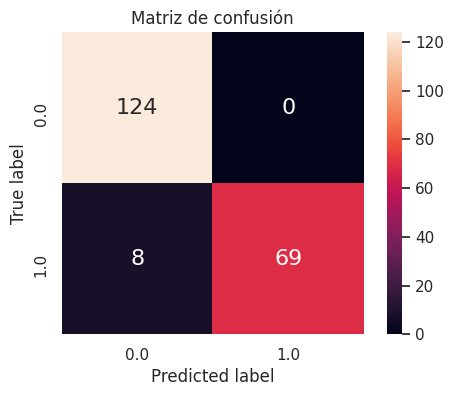

In [38]:
plot_confusion_matrix(y_test_2, knn_2.predict(X_test_2))

### 2do holdout

In [39]:
df_h_2 = segundo_set_de_preprocesados(holdout, columnas_nuevas)

df_h_2.head()

,tipo_de_sala_4d,tipo_de_sala_normal,tipo_de_sala_nan,id_usuario,genero_mujer,genero_nan,fila_medio,fila_nan,edad,parientes,precio_ticket,nombre_sede_fiumark_palermo,nombre_sede_fiumark_quilmes,nombre_sede_nan
0,1,0,0,0.751756,1,0,0,1,0.344774,0.0,0.000000,1,0,0
1,1,0,0,0.264637,1,0,0,1,0.063963,0.4,0.061224,1,0,0
2,0,1,0,0.026932,0,0,0,1,0.609984,0.0,0.040816,0,0,0
3,0,0,0,0.637002,0,0,0,1,0.407176,0.0,0.040816,1,0,0
4,1,0,0,0.471897,0,0,0,1,0.450858,0.0,0.000000,1,0,0


In [40]:
df_resultado_2 = evaluate_holdout(holdout, df_h_2, knn_2)
df_resultado_2.head(15)

y_pred.shape:  (90,)
holdout_df.shape:  (90, 14) 



,id_usuario,volveria
0,650,0
1,234,0
2,31,0
3,552,0
4,411,0
5,134,1
6,497,1
7,434,0
8,528,0
9,112,0


In [41]:
df_resultado_2.to_csv('prediccion/knn_2do_prepoc_resultado_final.csv')